In [1]:
import numpy as np
import tensorflow as tf
from utils import util_functions as utils

In [2]:
class FashionMNISTData(utils.DataModule):
  def __init__(self, batch_size=64, resize=(32, 32)):
    super().__init__()
    self.save_hyperparameters()
    self.train, self.val = tf.keras.datasets.fashion_mnist.load_data()
  
  def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3)/255, tf.cast(y, dtype='int32'))
    target_height, target_width = self.resize
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, target_height=target_height, target_width=target_width), y)
    shuffle_buffer = data[0].shape[0] if train else 1
    X, y = process(*data)
    X, y = resize_fn(X, y)
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(self.batch_size).shuffle(shuffle_buffer)
  
  def text_labels(self, indices):
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]
  
  def show_images(self, X, y, n_rows=1, n_cols=8, preds=None):
    import matplotlib.pyplot as plt
    _, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axs = axs.flatten()
    imgs = X.numpy()[:n_cols]
    labels = self.text_labels(list(y.numpy()[:n_cols]))
    if preds is not None:
      preds = self.text_labels(list(preds.numpy()[:n_cols]))
    else:
      preds = [None]*len(labels)
    for img, ax, label, pred in zip(imgs, axs, labels, preds):
        ax.imshow(img)
        title = label
        if pred:
          title = label + "\n" + pred 
        ax.set_title(title)
        
    plt.show()

In [3]:
data = FashionMNISTData(batch_size=256)
for X, y in data.train_dataloader():
  print(X.shape)
  print(y.shape)
  break

(256, 32, 32, 1)
(256,)


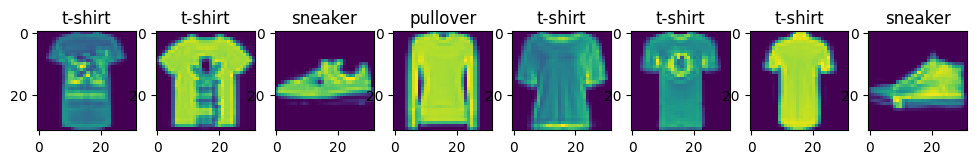

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
data.show_images(X, y)

## Base Model for Classification

In [5]:
class Classifier(utils.Module):
  def validation_step(self, batch):
    X_val, y_val = batch
    y_hat = self(X_val)
    l = self.loss(y_hat=y_hat, y=y_val)
    accuracy = self.accuracy(y_val, y_hat=y_hat)
    self.plot(key='loss', value=l, train=False)
    self.plot(key='accuracy', value=accuracy, train=False)

  def accuracy(self, y, y_hat):
    """
      y shape: (n_samples, )
      y_hat: (n_samples, n_classes) 
    """
    n_classes = y_hat.shape[-1]
    y_hat = tf.reshape(y_hat, (-1, n_classes))
    preds = tf.cast(tf.argmax(y_hat, axis=1), y.dtype)
    compare = tf.cast(preds == tf.reshape(y, (-1,)), tf.float32)
    return tf.reduce_mean(compare)

  def loss(self, y, y_hat):
    """
      y shape: (n_samples, )
      y_hat: (n_samples, n_classes) 
    """
    n_classes = y_hat.shape[-1]
    y_hat = tf.reshape(y_hat, (-1, n_classes))
    y = tf.reshape(y, (-1,))
    # y = tf.one_hot(y, depth=n_classes)
    # loss = -1*tf.reduce_mean(tf.math.log(tf.boolean_mask(y_hat, y)))
    fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = fn(y, y_hat)
    return loss

  def layer_summary(self, X_shape):
    X = tf.random.normal(shape=X_shape)
    for layer in self.net.layers:
      X = layer(X)
      print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [6]:
## Softmax Operation
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>

In [7]:
tf.reduce_sum(X, 1, keepdims=True)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 6.],
       [15.]], dtype=float32)>

In [8]:
def softmax(X):
  X_exp = tf.exp(X)
  partition =tf.reduce_sum(X_exp, axis=1, keepdims=True)
  return X_exp / partition

In [9]:
X = tf.random.normal(shape=(2, 5))
X

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 1.1131223 ,  2.5903342 , -1.4353046 , -2.0631623 ,  0.9496246 ],
       [ 0.01600038,  1.6962641 , -0.7911525 ,  0.59200186, -0.7900614 ]],
      dtype=float32)>

In [10]:
tf.reduce_sum(softmax(X), axis=1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9999999, 1.       ], dtype=float32)>

In [11]:
y_hat = softmax(X)
y_hat

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.15748458, 0.6898949 , 0.01231602, 0.00657348, 0.13373092],
       [0.11063633, 0.593782  , 0.04935779, 0.1968122 , 0.04941167]],
      dtype=float32)>

In [12]:
y = tf.constant([0, 2])
y

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 2], dtype=int32)>

In [13]:
num_classes = y_hat.shape[-1]
tf.one_hot(y, depth=num_classes)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

In [14]:
tf.boolean_mask(y_hat, tf.one_hot(y, depth=num_classes))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.15748458, 0.04935779], dtype=float32)>

In [15]:
-tf.reduce_mean(tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=num_classes))))

<tf.Tensor: shape=(), dtype=float32, numpy=2.4285436>

## Important Implementations
- Softmax
- Cross Entropy
- Accuracy

## Softmax Regression From Scratch

In [24]:
class SoftmaxRegressionScratch(Classifier):
  def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
    super().__init__(plot_train_per_epoch=1)
    self.save_hyperparameters()
    self.W = tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=sigma)
    self.b = tf.zeros(num_outputs)
    self.W = tf.Variable(self.W)
    self.b = tf.Variable(self.b)

  def forward(self, X):
    X = tf.reshape(X, (-1, self.W.shape[0]))
    return tf.matmul(X, self.W) + self.b

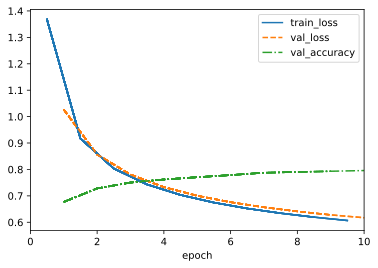

In [25]:
data = FashionMNISTData(resize=(28,28), batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.01)
Trainer = utils.Trainer(max_epochs=10)
Trainer.fit(model=model, data=data)

In [21]:
Trainer.num_train_batches

235

In [ ]:
data = FashionMNISTData(resize=(28,28))
for X, y in data.val_dataloader():
  print(X.shape)
  preds = tf.argmax(model(X), axis=1)
  break

In [ ]:
preds.shape

In [ ]:
y

In [ ]:
preds

In [ ]:
data.show_images(X=X, y=y, preds=preds)

## Concise Implementation of Softmax Regression

In [12]:
import tensorflow as tf
from utils import util_functions as utils

In [10]:
class SoftmaxRegression(Classifier):
  def __init__(self, num_outputs, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = tf.keras.models.Sequential()
    self.net.add(tf.keras.layers.Flatten())
    self.net.add(tf.keras.layers.Dense(units=num_outputs))

  def forward(self, X):
    return self.net(X)

In [ ]:
data = FashionMNISTData(resize=(28,28))
model = SoftmaxRegression(num_outputs=10, lr=0.01)
Trainer = utils.Trainer(max_epochs=10)
Trainer.fit(model=model, data=data)

In [12]:
def relu(X):
  return tf.math.maximum(X, 0)

class MLPScratch(Classifier):
  def __init__(self, num_inputs=784, num_hiddens=256, num_outputs=10, lr=0.1, sigma=0.1):
    super().__init__()
    self.save_hyperparameters()
    self.W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens))*sigma)
    self.b1 = tf.Variable(tf.zeros(shape=(num_hiddens)))
    self.W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs))*sigma)
    self.b2 = tf.Variable(tf.zeros(shape=(num_outputs)))
  
  def forward(self, X):
    X = tf.reshape(X, (-1, self.num_inputs))
    H = relu(tf.matmul(X, self.W1) + self.b1)
    return tf.matmul(H, self.W2) + self.b2

In [ ]:
data = FashionMNISTData(resize=(28,28))
model = MLPScratch()
Trainer = utils.Trainer(max_epochs=10)
Trainer.fit(model=model, data=data)